In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import random
from glob import  glob

from torchvision.datasets import  ImageFolder
%matplotlib inline

In [2]:
#  available cuda and def seed
dev = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(42)

In [3]:
# get dir path
dir_train = "./dataset/chest_xray/train/"
dir_test = "./dataset/chest_xray/test/"

Random image path: NORMAL
Image class: train
Image shape (1604, 1986)


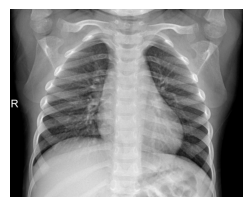

In [4]:
# get all images
image_path_list = list(glob(dir_train +"*/*.jpeg"))

random_image_path = random.choice(image_path_list) # pick a random image
parent = os.path.dirname(random_image_path) # parent file and parent image
img = Image.open(random_image_path) # open image 

# view with plt
img_plt = np.asarray(img)
plt.figure(figsize=(3,3))
plt.imshow(img_plt, cmap="gray")
print(f"Random image path: {parent.split('/')[4]}")
print(f"Image class: {parent.split('/')[3]}")
print(f"Image shape {img_plt.shape}")
plt.axis(False);


## transform and prepare Dataloader

In [5]:
train_transform = transforms.Compose([ transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([ transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])])

In [6]:
# Use ImageFolder to create dataset
train_data = ImageFolder(root=dir_train, transform=train_transform, target_transform=None)
test_data = ImageFolder(root=dir_test, transform=test_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 5232
    Root location: ./dataset/chest_xray/train/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 624
    Root location: ./dataset/chest_xray/test/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [7]:
# prepare DataLoader
BATCH_SIZE = 200 # divide el dataseth en n partes

train_dataloader = DataLoader(dataset= train_data, batch_size=BATCH_SIZE,shuffle= True, pin_memory=True) 
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [8]:
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')


['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()        

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=0, bias=False),
            nn.ReLU())
        self.pool_11 = nn.MaxPool2d(2)
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, bias=False),
            nn.ReLU())
        self.pool_22 = nn.MaxPool2d(2)

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1, padding=0, bias=False),
            nn.ReLU())
        self.pool_33 = nn.MaxPool2d(2)

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias=False),
            nn.ReLU())        

        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=1, padding=0, bias=False),
            nn.ReLU())

        self.conv_block_6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, padding=0, bias=False),
            nn.ReLU())
        
        self.conv_block_7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, bias=False),
            nn.ReLU())
        
        self.conv_block_8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=1, padding=0, bias=False),
            nn.ReLU())

        self.conv_block_9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, padding=0, bias=False),
            nn.ReLU())

        self.conv_block_10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=3, padding=0, bias=False),
            nn.ReLU())

        self.conv_block_11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=3, padding=0, bias=False),
            nn.ReLU())

        self.gap = nn.Sequential( nn.AvgPool2d(4))
        
        self.conv_block_out = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=4, padding=0, bias=False))
    
    def forward(self, x):
        x = self.conv_block_out( self.gap( self.conv_block_11( self.conv_block_10( self.conv_block_9(
            self.conv_block_8( self.conv_block_7( self.conv_block_6( self.conv_block_5(
                self.conv_block_4( self.pool_33( self.conv_block_3( self.pool_22(
                    self.conv_block_2( self.pool_11( self.conv_block_1(x)))
                ))))
            ))))
        )))))
        x = x.view(-1,2)
        return F.log_softmax(x, dim=-1)

set_seed(42)
model = Net().to(dev)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv2d-14           [-1, 10,

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831440/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
